In [4]:
import sys
import jax.numpy as jnp
import numpy as np
from trax import layers as tl
from trax.shapes import signature
from trax.layers import combinators as cb
from trax.layers.assert_shape import assert_shape

sys.path.insert(0, "../..")
from src.models.build import summary
from src.settings import GeneralSettings
from pathlib import Path
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt
%matplotlib inline
settings = GeneralSettings()
data_dir = settings.data_dir

/Users/rgrouls/Library/Caches/pypoetry/virtualenvs/deep-learning-xB8KIJr7-py3.9/lib/python3.8/site-packages/torchvision/transforms/functional_pil.py:228: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  interpolation: int = Image.BILINEAR,
/Users/rgrouls/Library/Caches/pypoetry/virtualenvs/deep-learning-xB8KIJr7-py3.9/lib/python3.8/site-packages/torchvision/transforms/functional_pil.py:295: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  interpolation: int = Image.NEAREST,
/Users/rgrouls/Library/Caches/pypoetry/virtualenvs/deep-learning-xB8KIJr7-py3.9/lib/python3.8/site-packages/torchvision/transforms/functional_pil.py:328: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  interpolation: int = Image.BICUBIC,


So far, we have seen supervised methods that use a label.
However, sometimes you want something more generic than you can create with a label.

One approach are autoencoders. These architectures can be used for various purposes:

- noise reduction / denoising
- image coloring
- dimensionality reduction
- watermark removal
- anomaly detection

So, as you can see, a lot of different approaches.

The architecture should also look familiar; it uses a bottleneck, just like we have seen before in the SENet implementation. An autoencoder looks like this:

<img src="https://uvadlc-notebooks.readthedocs.io/en/latest/_images/autoencoder_visualization.svg">

The novelty here is: you feed the model *exactly the same* image that went in, as a label!

Or, with some slight variations: you feed the model the image + random noise as input, and the clean image as output; or a black-and-white version as input, and a colored version as output; or a watermarked image as input, and a clean version as output.

The bottleneck has just $z$ dimensions. That means the model is forced the throw way anything that is not relevant, and it has to learn how to reconstruct a complete new image, just from a small vector.

# Load data
First, let's load the familiar MNIST

In [5]:
from torchvision import datasets
training_data = datasets.MNIST(
    root=data_dir,
    train=True,
    download=True,
    transform=ToTensor(),
)

test_data = datasets.MNIST(
    root=data_dir,
    train=False,
    download=True,
    transform=ToTensor(),
)

So, we will need to modify the streamer. We will do it like this, where we inherit everything from the base streamer, but we just change the output (X,Y) for (X, X): the goal is to reconstruct the input!

In [6]:
from src.data.data_tools import BaseDatastreamer
from typing import Iterator

class VAEstreamer(BaseDatastreamer):
    def stream(self) -> Iterator:
        while True:
            if self.index > (self.size - self.batchsize):
                self.reset_index()
            batch = self.batchloop()
            # we throw away the Y
            X_, _ = zip(*batch) 
            X = np.stack(X_)
            # change the channel to channel-last
            X = X.transpose(0, 2, 3, 1)
            # and yield X, X
            yield X, X

trainstream = VAEstreamer(dataset=training_data, batchsize=32).stream()
teststream = VAEstreamer(dataset=test_data, batchsize=32).stream()
X1, X2 = next(trainstream)
X1.shape, X2.shape

((32, 28, 28, 1), (32, 28, 28, 1))

So far, this works as expected. 

# The encoder
We have an encoder and a decoder part. Let's focus on the encoder.

You could do this in many ways:

1. Flatten the image and use simple linear layers + activations to reduce the dimensions 
2. Build a CNN network with Conv / Maxpool layers
3. Use a pretrained model like ResNet18, and swap the last layer (like I showed in lesson 4, notebook 5_lr_schedulers_with_resnet) to reduce the dimensionality to our desired latent dimension $z$

Probably, option 3. is the most robust. But because it is MNIST, we can probably get away with option 1. and it is the simplest way. So let's start there.

In [7]:
hidden = 32
latent = 2

def Encoder(hidden: int, latent: int):
    encoder = cb.Serial(
        tl.Flatten(),
        tl.Dense(250),
        tl.Relu(),
        tl.Dense(100),
        tl.Relu(),
        tl.Dense(latent)
    ) 
    return encoder
encoder = Encoder(hidden, latent)
encoder.init_weights_and_state(signature(X1))
summary(encoder, X1)

layer                   input                dtype     output               dtype 
(0) Flatten_keep1       (32, 28, 28, 1)    (float32) | (32, 784)          (float32)
(1) Dense_250           (32, 784)          (float32) | (32, 250)          (float32)
(2) Relu                (32, 250)          (float32) | (32, 250)          (float32)
(3) Dense_100           (32, 250)          (float32) | (32, 100)          (float32)
(4) Relu                (32, 100)          (float32) | (32, 100)          (float32)
(5) Dense_2             (32, 100)          (float32) | (32, 2)            (float32)


ShapeDtype{shape:(32, 2), dtype:float32}

This should be something you have seen multiple times by now. We Flatten to 784, and then reduce in steps 784 -> 250 -> 100 -> 2.

This is a very basic approach, and you could probably finetune that, but let's just go with this for now.

Now, we build the decoder. It is the same network, but the other way around:
2 -> 100 -> 250 -> 784

We will need a function to reshape the 784 numbers back to a (28,28,1) image. Using the -1 in the shape means: whatever numbers makes this fit.

So, you can calculate that $784 / (28*28*1) = 32$, to the reshape figures out that this should be (32, 28, 28, 1)

In [8]:
z = encoder(X1)
z.shape

(32, 2)

In [9]:
def Expand(shape):
    def f(x):
        return x.reshape(shape)
    return tl.Fn("Expand", f)

def Decoder(hidden: int):
    decoder = cb.Serial(
        tl.Dense(100),
        tl.Relu(),
        tl.Dense(250),
        tl.Relu(),
        tl.Dense(28*28),
        Expand((-1, 28, 28, 1))
    ) 
    return decoder

decoder = Decoder(hidden)
decoder.init_weights_and_state(signature(z))
summary(decoder, z)

layer                   input                dtype     output               dtype 
(0) Dense_100           (32, 2)            (float32) | (32, 100)          (float32)
(1) Relu                (32, 100)          (float32) | (32, 100)          (float32)
(2) Dense_250           (32, 100)          (float32) | (32, 250)          (float32)
(3) Relu                (32, 250)          (float32) | (32, 250)          (float32)
(4) Dense_784           (32, 250)          (float32) | (32, 784)          (float32)
(5) Expand              (32, 784)          (float32) | (32, 28, 28, 1)    (float32)


ShapeDtype{shape:(32, 28, 28, 1), dtype:float32}

This works too. For the loss, we will use MSE. Predicting a pixel value of 250 instead of 254 is not that important, but confusing 0 with 255 is much worse.

Instead of predicting a probability per pixel, we will just use the distance, which simplifies the training. A downside of this is that you get sort of blurry images where small noise patterns are removed because those cause a very low error.

Also, if you move an image one pixel to the left, it should get a low loss, but with MSE the loss can be very high because every pixel is different. There are other ways to calculate the loss (e.g. have a pretrained resnet encode the image, and use the distance between the featuremaps as a loss)

We will use the reconstruction loss (which is a sligth variation on the MSE) as suggested [in this UVA course](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial9/AE_CIFAR10.html)

In [10]:
def ReconstructionLoss():
    def f(y, yhat):
        squared_error = (y-yhat)**2
        summed = jnp.sum(squared_error, axis=[1,2,3])
        return summed.mean()
    return tl.Fn("recostructionLoss", f)
    

Now we have everything we need, let's put it together

In [11]:
@assert_shape('bwhc->bwhc')
def AutoEncoder(hidden: int, latent: int):
    encoder = Encoder(hidden, latent)
    decoder = Decoder(hidden)
    model = cb.Serial(
        encoder,
        decoder
    )
    return model


And test it

In [12]:
model = AutoEncoder(hidden=32, latent=2)
model.init_weights_and_state(signature(X1))
summary(model, X1)

layer                   input                dtype     output               dtype 
(0) Flatten_keep1       (32, 28, 28, 1)    (float32) | (32, 784)          (float32)
(1) Dense_250           (32, 784)          (float32) | (32, 250)          (float32)
(2) Relu                (32, 250)          (float32) | (32, 250)          (float32)
(3) Dense_100           (32, 250)          (float32) | (32, 100)          (float32)
(4) Relu                (32, 100)          (float32) | (32, 100)          (float32)
(5) Dense_2             (32, 100)          (float32) | (32, 2)            (float32)
(1) Dense_100           (32, 2)            (float32) | (32, 100)          (float32)
(2) Relu                (32, 100)          (float32) | (32, 100)          (float32)
(3) Dense_250           (32, 100)          (float32) | (32, 250)          (float32)
(4) Relu                (32, 250)          (float32) | (32, 250)          (float32)
(5) Dense_784           (32, 250)          (float32) | (32, 784)          (fl

ShapeDtype{shape:(32, 28, 28, 1), dtype:float32}

This is looking good. We can start training now

In [30]:
from trax.supervised import training
from src.data import data_tools
import trax

model = AutoEncoder(hidden=32, latent=2)
log_dir = "../../models/trax"
log_dir = data_tools.dir_add_timestamp(log_dir)

train_task = training.TrainTask(
    labeled_data=trainstream,
    loss_layer=ReconstructionLoss(),
    optimizer=trax.optimizers.Adam(),
)

eval_task = training.EvalTask(
    labeled_data=teststream, metrics=[ReconstructionLoss()], n_eval_batches=25
)

loop = training.Loop(
    model,
    train_task,
    eval_tasks=[eval_task],
    output_dir=log_dir,
)

2022-06-13 12:18:30.725 | INFO     | src.data.data_tools:dir_add_timestamp:228 - Logging to ../../models/trax/20220613-1218
/Users/rgrouls/Library/Caches/pypoetry/virtualenvs/deep-learning-xB8KIJr7-py3.9/lib/python3.8/site-packages/jax/_src/lib/xla_bridge.py:429: UserWarning: jax.host_count has been renamed to jax.process_count. This alias will eventually be removed; please update your code.
  warnings.warn(


In [31]:
loop.run(4000)


Step      1: Total number of trainable weights: 443886
Step      1: Ran 1 train steps in 2.25 secs
Step      1: train recostructionLoss |  85.81388855
Step      1: eval  recostructionLoss |  90.65213776

Step    100: Ran 99 train steps in 1.11 secs
Step    100: train recostructionLoss |  65.50271606
Step    100: eval  recostructionLoss |  49.45854568

Step    200: Ran 100 train steps in 0.91 secs
Step    200: train recostructionLoss |  48.91945648
Step    200: eval  recostructionLoss |  48.41117859

Step    300: Ran 100 train steps in 0.95 secs
Step    300: train recostructionLoss |  46.61704254
Step    300: eval  recostructionLoss |  45.12106323

Step    400: Ran 100 train steps in 0.97 secs
Step    400: train recostructionLoss |  44.96337509
Step    400: eval  recostructionLoss |  45.06121445

Step    500: Ran 100 train steps in 0.95 secs
Step    500: train recostructionLoss |  44.39855576
Step    500: eval  recostructionLoss |  43.13558960

Step    600: Ran 100 train steps in 0.96 

The model will do better with a slightly bigger latent size, but 2 makes it easy to plot things later on.

In [19]:
# load trained model from disk
# model.init_from_file("../../models/trax/20220613-1218/model.pkl.gz")

100%|██████████| 9/9 [00:00<00:00, 450.52it/s]


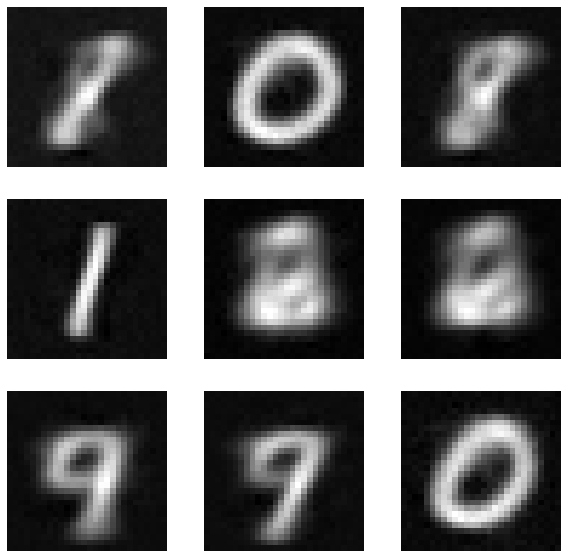

In [20]:
from src.visualization.visualize import plot_grid
X, Y = next(teststream)
img = model(X)
plot_grid(img)

As you can see, a bit blurry. But still, this is reconstructed from just two numbers!

# exploring the Encoder
We can now extract the encoder sublayer from the model.

In [21]:
encoder = model.sublayers[1].sublayers[0]
y = encoder(X)
summary(encoder, X)

layer                   input                dtype     output               dtype 
(0) Flatten_keep1       (32, 28, 28, 1)    (float32) | (32, 784)          (float32)
(1) Dense_250           (32, 784)          (float32) | (32, 250)          (float32)
(2) Relu                (32, 250)          (float32) | (32, 250)          (float32)
(3) Dense_100           (32, 250)          (float32) | (32, 100)          (float32)
(4) Relu                (32, 100)          (float32) | (32, 100)          (float32)
(5) Dense_2             (32, 100)          (float32) | (32, 2)            (float32)


ShapeDtype{shape:(32, 2), dtype:float32}

We now have a trained encoder, that will compress an 28x28 MNIST image into 2 numbers, in such a way that it makes sense for reconstruction. Lets visualize this with tensorboard.

In [30]:
from torch.utils.tensorboard import SummaryWriter
import tensorboard as tb
import tensorflow as tf
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile
import torch

writer = SummaryWriter(log_dir="../../models/embeddings/")
def select_n_random(data, labels, n=100):
    '''
    Selects n random datapoints and their corresponding labels from a dataset
    '''
    assert len(data) == len(labels)

    perm = torch.randperm(len(data))
    return data[perm][:n], labels[perm][:n]

# select random images and their target indices
images, labels = select_n_random(test_data.data, test_data.targets)

# get the class labels for each image
# class_labels = [classes[lab] for lab in labels]

# log embeddings
features = images.view(-1, 28 * 28)
writer.add_embedding(features,
                    metadata=labels,
                    label_img=images.unsqueeze(1))
writer.close()

It should look something like this:

<img src="../../reports/figures/embeddings.png" width="500">

Which is a 3d project of the embeddings. Nice thing is, this works too if your latent size has a higher dimension, eg $z=10$.
Play around with it yourself to get a better feeling.

So, the encoder acts as a clustering alogorithm. You could compare it to PCA, but PCA will only find linear relationships and our model can also project non-linear cluster.

You see the images are nicely grouped: you input an (28, 28, 1) image, and you get a location with $z$ coordinates on a "map" where similar images are closer to each other.
This can be very usefull, and can serve as a basis for further clustering.

# Exploring the decoder

To explore the decoder, we need to input just two numbers, and our model with create an image from that.
To get a good idea of the range, we will query the teststream for 10 batches and store the min and max values.

In [31]:
minmax = []
for _ in range(10):
    X, _ = next(teststream)
    y = encoder(X)
    minmax.append(y.min())
    minmax.append(y.max())
minmax = np.array(minmax)
minmax.min(), minmax.max()

(-8.905635, 11.813516)

So, let's create a 2D grid that ranges from the minumum value all the way to the maximum value, 
and fill that grid with combinations of two numbers

In [33]:
decoder = model.sublayers[1].sublayers[1]
k = 20
x = np.linspace(minmax.min(), minmax.max(), k)
y = np.linspace(minmax.min(), minmax.max(), k)
xx, yy = np.meshgrid(x, y)
grid = np.c_[xx.ravel(), yy.ravel()]
grid.shape

(400, 2)

So this are 400 coordinates, ranging from (min, min) in small steps going all the way up to (max, max)

Now let's visualize what our model makes from these numbers

100%|██████████| 400/400 [00:00<00:00, 523.11it/s]


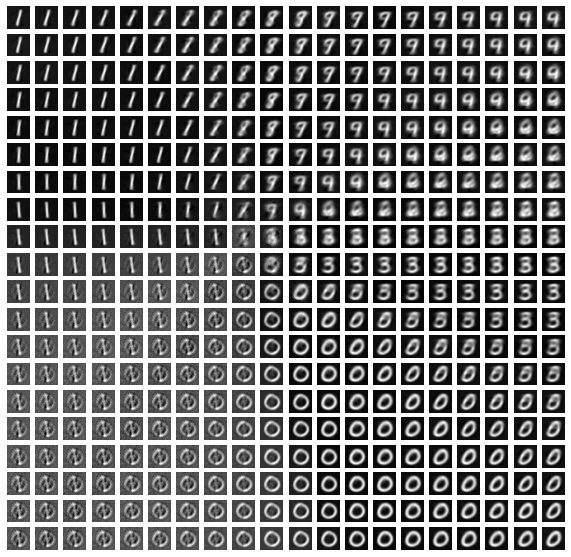

In [34]:
img = decoder(grid)
plot_grid(img, k=k)

Well, look at that! You can see that tweaking one of the two numbers, and image will slowly morph from an 8 into a 3 into a 5 into a 0.

The model has created a latent encoding $z$, with just two numbers, that can act as a dial.
Changing the dial will create images of different types.

I hope you can imagine that there are lot's of things you can do with this; from generating faces to removing noise.